In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.file_reader import MatFileReader
from gait_modulation.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.feature_extractor import FeatureExtractor


# Loading the data

In [2]:
# Handle multiple patients with nested directories.
root_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data'
mat_reader = MatFileReader(root_directory, max_workers=1)  #  adjust the number of workers for parallelism

# Read all data from nested folders of multiple patients and sessions
all_data = mat_reader.read_data()
n_sessions = len(all_data)

print(f"Number of sessions: {n_sessions}")

Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_4_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/mast

In [3]:
# Access specific sessions for a patient
session = all_data[0] # pick any session e.g. first one to load the meta data

# Extract LFP meta data for subject/session
lfp_metadata = DataProcessor.np_to_dict(session['hdr_LFP'])

# Load LFP parameters
lfp_sfreq = lfp_metadata['Fs'].item()
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels'].item()

# Prepare for mne data structure
info = mne.create_info(ch_names=lfp_ch_names[0:6], sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Select one event to work with: mod_start
event_of_interest = 'mod_start'
mod_start_event_id = 1

# Define normal walking events
normal_walking_event_id = -1

# Define the event dictionary
event_dict = {
    'mod_start': mod_start_event_id,
    'normal_walking': normal_walking_event_id
}

# Define parameters
epoch_tmin = -2.0
epoch_tmax = 0.0
epoch_duration = epoch_tmax - epoch_tmin
epoch_sample_length = int(epoch_duration * lfp_sfreq)
gap_duration = 10  # At least 10 seconds away from modulation events
gap_sample_length = int(gap_duration * lfp_sfreq)

epochs_list = []
events_list = []

for s in range(n_sessions):
    print(f'Session: {s}')
    session = all_data[s] # Access specific patient/sessions

    # Extract events and lfp data of the subject/session
    lfp_data = session['data_LFP'] * 1e-6  # Convert microvolts to volts
    
    # lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)
    # lfp_raw.plot(start=0, duration=np.inf, remove_dc=False)
    # plt.show()

    # Handle events
    events_KIN = DataProcessor.np_to_dict(session['events_KIN'])
    events_before_trim, event_dict_before_trim = DataProcessor.create_events_array(events_KIN, lfp_sfreq)

    # Trim the data and adjust the event onsets accordingly
    lfp_data, events_after_trim = DataProcessor.trim_data(lfp_data, events_before_trim, lfp_sfreq)
    lfp_duration = lfp_data.shape[1] / lfp_sfreq
    n_samples = int(lfp_duration * lfp_sfreq)

    # Update raw data after trimming
    lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)

    # events_mod_start = events_before_trim[events_before_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    events_mod_start = events_after_trim[events_after_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    events_mod_start[:, 1] = s # mark the session nr  
    # print("--->", np.unique(events_mod_start[:, 1]), np.unique(events_mod_start[:, 2], return_counts=True))

    # Rename Gait Modulation Events
    events_mod_start[:, 2] = mod_start_event_id
        
    # Define normal walking events
    normal_walking_events = DataProcessor.define_normal_walking_events(
        normal_walking_event_id, events_mod_start,
        gap_sample_length, epoch_sample_length, n_samples
    )
    
    events_mod_start[:, 1] = s # mark the session nr
    normal_walking_events[:, 1] = s # mark the session nr

    # ## Remove artifacts from raw LFP data using ICA.
    # ica_n_components = 6 # 6 = n_channels.
    # ica = mne.preprocessing.ICA(n_components=ica_n_components, random_state=97, max_iter=800, verbose=40)
    # print(lfp_raw.ch_names)
    # ica.fit(lfp_raw)
    # raw_data_clean = ica.apply(lfp_raw, verbose=40) # Apply ICA to the raw data

    # Combine events and create epochs
    events, epochs = DataProcessor.create_epochs_with_events(
        lfp_raw,
        events_mod_start,
        normal_walking_events,
        mod_start_event_id,
        normal_walking_event_id,
        epoch_tmin,
        epoch_tmax,
        event_dict
    )
    print(f"Total epochs: {len(epochs)}")
    for cls in event_dict.keys():
        print(f"{cls}: {len(epochs[cls])} epochs", end='; ')
    
    # events[:, 1] = s # No need to mark the session nr for events again!
    epochs.events[:, 1] = s # mark the session nr
    
    my_annot = mne.Annotations(
        onset=(events[:, 0] - epoch_sample_length) / lfp_sfreq,  # in seconds
        # onset=events[:, 0]/lfp_sfreq,  # in seconds
        duration=len(events)*[epoch_duration],  # in seconds, too
        description=events[:, 2],
    )
    lfp_raw.set_annotations(my_annot)
    
    fig = lfp_raw.plot(start=0, duration=np.inf, show=False) # lfp_duration
    fig.suptitle(f'Session {s}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/session{s}.png')
    plt.close(fig)
    
    epochs_list.append(epochs)
    events_list.append(events)
    
    print("\n==========================================================")


epochs = mne.concatenate_epochs(epochs_list, verbose=40)
events = np.vstack(events_list)
events = events[np.argsort(events[:, 0])]  # TODO: Sort by onset time

# Preprocessing
## Apply band-pass filtering to the raw LFP data.
l_freq = 1
h_freq = 50
epochs.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=40)

Session: 0
Number of samples removed: 14738
Number of seconds removed: 58.95 seconds
Total epochs: 105
mod_start: 8 epochs; normal_walking: 97 epochs; Using matplotlib as 2D backend.

Session: 1
No trimming needed as the beginning of signal is not flat.
Total epochs: 64
mod_start: 6 epochs; normal_walking: 58 epochs; 
Session: 2
Number of samples removed: 2282
Number of seconds removed: 9.13 seconds
Total epochs: 25
mod_start: 15 epochs; normal_walking: 10 epochs; 
Session: 3
Number of samples removed: 7049
Number of seconds removed: 28.20 seconds
Total epochs: 21
mod_start: 12 epochs; normal_walking: 9 epochs; 
Session: 4
Number of samples removed: 1950
Number of seconds removed: 7.80 seconds
Total epochs: 53
mod_start: 8 epochs; normal_walking: 45 epochs; 

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/1716625030.py:110: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 5
No trimming needed as the beginning of signal is not flat.
Total epochs: 28
mod_start: 11 epochs; normal_walking: 17 epochs; 

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/1716625030.py:110: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 6
Number of samples removed: 1819
Number of seconds removed: 7.28 seconds
Total epochs: 40
mod_start: 8 epochs; normal_walking: 32 epochs; 
Session: 7
Number of samples removed: 672
Number of seconds removed: 2.69 seconds
Total epochs: 26
mod_start: 11 epochs; normal_walking: 15 epochs; 
Session: 8
No trimming needed as the beginning of signal is not flat.
Total epochs: 40
mod_start: 13 epochs; normal_walking: 27 epochs; 
Session: 9
Number of samples removed: 731
Number of seconds removed: 2.92 seconds
Total epochs: 26
mod_start: 15 epochs; normal_walking: 11 epochs; 
Session: 10
No trimming needed as the beginning of signal is not flat.
Total epochs: 85
mod_start: 3 epochs; normal_walking: 82 epochs; 
Session: 11
Number of samples removed: 3215
Number of seconds removed: 12.86 seconds
Total epochs: 54
mod_start: 10 epochs; normal_walking: 44 epochs; 

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/1716625030.py:110: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 12
Number of samples removed: 6608
Number of seconds removed: 26.43 seconds
Total epochs: 66
mod_start: 5 epochs; normal_walking: 61 epochs; 
Session: 13
Number of samples removed: 13713
Number of seconds removed: 54.85 seconds
Total epochs: 48
mod_start: 5 epochs; normal_walking: 43 epochs; 

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/1716625030.py:110: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  lfp_raw.set_annotations(my_annot)



Session: 14
Number of samples removed: 1090
Number of seconds removed: 4.36 seconds
Total epochs: 42
mod_start: 9 epochs; normal_walking: 33 epochs; 
Session: 15
Number of samples removed: 13850
Number of seconds removed: 55.40 seconds
Total epochs: 34
mod_start: 8 epochs; normal_walking: 26 epochs; 

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/1716625030.py:110: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  lfp_raw.set_annotations(my_annot)


Number of events,757
Events,mod_start: 147normal_walking: 610
Time range,-2.000 – 0.000 s
Baseline,off


In [4]:
Visualise.plot_event_occurrence(events=events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'plots/event_classes.png')


Visualise.plot_event_occurrence(events=epochs.events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'plots/epochs.event_classes.png')

Plot saved as plots/event_classes.png
Plot saved as plots/epochs.event_classes.png


In [5]:
Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'plots/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'plots/epochs.event_class_histogram.png')

Plot saved as plots/event_class_histogram.png
Plot saved as plots/epochs.event_class_histogram.png


In [6]:
epochs.save("processd/lfp_epo.fif", overwrite=True)

Overwriting existing file.
Overwriting existing file.


# Feature Extraction

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.file_reader import MatFileReader
from gait_modulation.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.feature_extractor import FeatureExtractor

In [8]:
epochs = mne.read_epochs('processd/lfp_epo.fif')

Reading /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/processd/lfp_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -2000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
757 matching events found
No baseline correction applied
0 projection items activated


In [9]:
epochs.get_data(copy=False).shape

(757, 6, 501)

In [10]:
def extract_band_power(epochs, freq_bands):
    """
    Extracts band power features from each channel of the given MNE epochs without averaging across channels.
    
    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    
    Returns:
    - band_power_dict: A dictionary where each key corresponds to a frequency band, and values are lists of features
                    (1 for each epoch and channel) for that specific band.
    """
    band_power_dict = {band: [] for band in freq_bands}  # Initialize the dictionary for each band
    
    # Compute PSD using the `compute_psd` function from MNE's Epochs object
    psds, freqs = epochs.compute_psd(fmin=min([f[0] for f in freq_bands.values()]), 
                                    fmax=max([f[1] for f in freq_bands.values()])).get_data(return_freqs=True)
    
    # Convert power spectral density (psd) to decibels
    psds_db = 10 * np.log10(psds)

    # Extract band power for each band and channel
    for band, (low, high) in freq_bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)  # Find frequency indices within this band
        
        # For each epoch, and for each channel, calculate the mean power for this band
        band_power_dict[band] = psds_db[:, :, idx_band].mean(axis=-1)  # Mean over frequency range (axis=-1)
        
    return band_power_dict

freq_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 60)
}

# The result is a dictionary where each key corresponds to a band, and values are arrays (n_epochs, n_channels)
band_power_features = extract_band_power(epochs, freq_bands)
print(band_power_features['delta'].shape) # (freq band: {n_epochs x n_channels})

    Using multitaper spectrum estimation with 7 DPSS windows
(757, 6)


In [11]:
def extract_band_psd(epochs, freq_bands):
    """
    Extracts PSD features for specified frequency bands from the given MNE epochs without averaging across channels or frequencies.
    
    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    
    Returns:
    - psd_dict: A dictionary where each key corresponds to a frequency band, and values are arrays
                of shape (n_epochs, n_channels, n_frequencies) representing the raw PSD values for each band.
    """
    psd_dict = {band: [] for band in freq_bands}  # Initialize the dictionary for each band
    
    # Compute PSD using the `compute_psd` function from MNE's Epochs object
    psds, freqs = epochs.compute_psd(fmin=min([f[0] for f in freq_bands.values()]), 
                                         fmax=max([f[1] for f in freq_bands.values()])).get_data(return_freqs=True)

    # Extract PSD for each band and channel
    for band, (low, high) in freq_bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)  # Find frequency indices within this band
        
        # Extract raw PSD values for each frequency in the band for each epoch and channel
        psd_dict[band] = psds[:, :, idx_band]  # No mean over frequencies, retain raw PSD values
    
    return psd_dict  # (n_epochs, n_channels, n_frequencies)


# Assuming `epochs` is your MNE Epochs object
psd_features = extract_band_psd(epochs, freq_bands)
psd_features['gamma'].shape # ((freq band: {n_epochs, n_channels, n_frequencies})

    Using multitaper spectrum estimation with 7 DPSS windows


(757, 6, 60)

In [12]:
def compute_overall_psd(epochs, fmin=1, fmax=50):
    """
    Computes the overall PSD across all channels and epochs from the MNE epochs object.
    
    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - fmin: Minimum frequency for PSD computation (default is 1 Hz).
    - fmax: Maximum frequency for PSD computation (default is 50 Hz).
    
    Returns:
    - psds_db: PSD values in decibels.
    - freqs: Corresponding frequency values.
    """
    # Compute PSD across all frequencies from fmin to fmax
    psds, freqs = epochs.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    
    # Convert PSD to decibels (optional)
    psds_db = 10 * np.log10(psds)
    
    return psds_db, freqs  # Return both the psds and the corresponding frequencies

# Extract PSD features
overall_psd_features, overall_psd_freqs = compute_overall_psd(epochs)
overall_psd_features.shape

    Using multitaper spectrum estimation with 7 DPSS windows


(757, 6, 98)

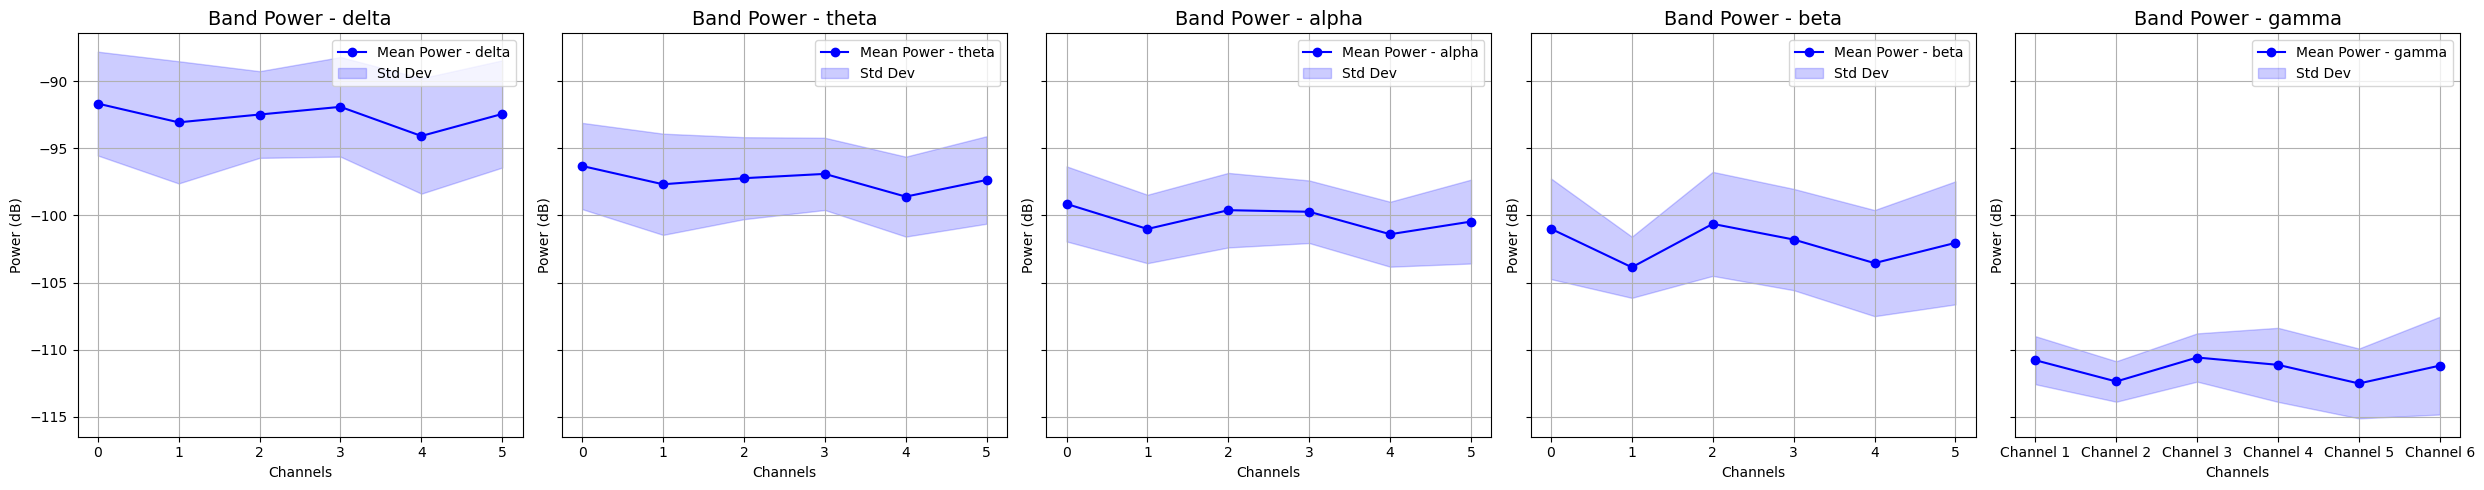

In [13]:
def visualize_band_power(band_power_features):
    """
    Visualizes the band power features stored in a dictionary.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data) in zip(axes, band_power_features.items()):
        # Calculate mean and standard deviation across epochs for each channel
        mean_power = np.mean(data, axis=0)  # Mean across epochs
        std_power = np.std(data, axis=0)    # Std deviation across epochs

        # Plot mean band power for each channel
        ax.plot(mean_power, label=f'Mean Power - {band}', color='blue', marker='o')
        ax.fill_between(range(data.shape[1]), mean_power - std_power, mean_power + std_power, 
                        color='blue', alpha=0.2, label='Std Dev')
        
        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data.shape[1]), labels=[f'Channel {i+1}' for i in range(data.shape[1])])
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data.
visualize_band_power(band_power_features)

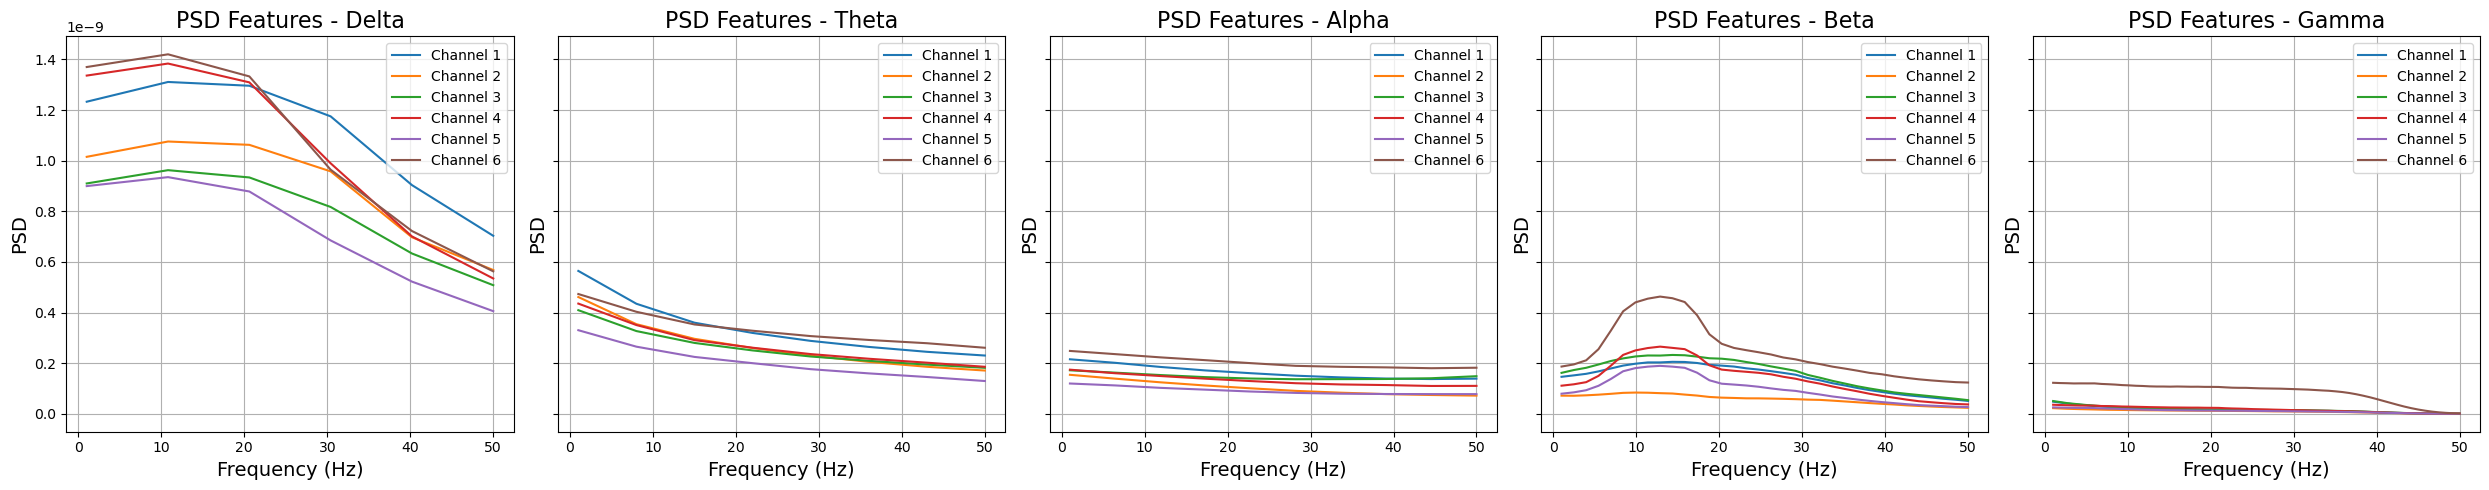

In [14]:
def visualize_psd(psd_features):
    """
    Visualizes the PSD features for each frequency band.
    
    Parameters:
    - psd_features: Dictionary with frequency bands as keys and values as 
                    arrays of shape (n_epochs, n_channels, n_frequencies).
    """
    num_bands = len(psd_features)
    num_channels = next(iter(psd_features.values())).shape[1]  # Get number of channels

    # Create a figure with subplots for each frequency band
    fig, axes = plt.subplots(1, num_bands, figsize=(5 * num_bands, 5), sharey=True)
    
    # Plot each band
    for i, (band, values) in enumerate(psd_features.items()):
        mean_psd = values.mean(axis=0)  # Average across epochs
        freqs = np.linspace(1, 50, values.shape[2])  # Example frequency range (adjust as necessary)
        
        for ch in range(num_channels):
            axes[i].plot(freqs, mean_psd[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels
        axes[i].set_title(f'PSD Features - {band.capitalize()}', fontsize=16)
        axes[i].set_xlabel('Frequency (Hz)', fontsize=14)
        axes[i].set_ylabel('PSD', fontsize=14)
        axes[i].legend(loc='upper right')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
    
visualize_psd(psd_features) # Plot PSD features

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


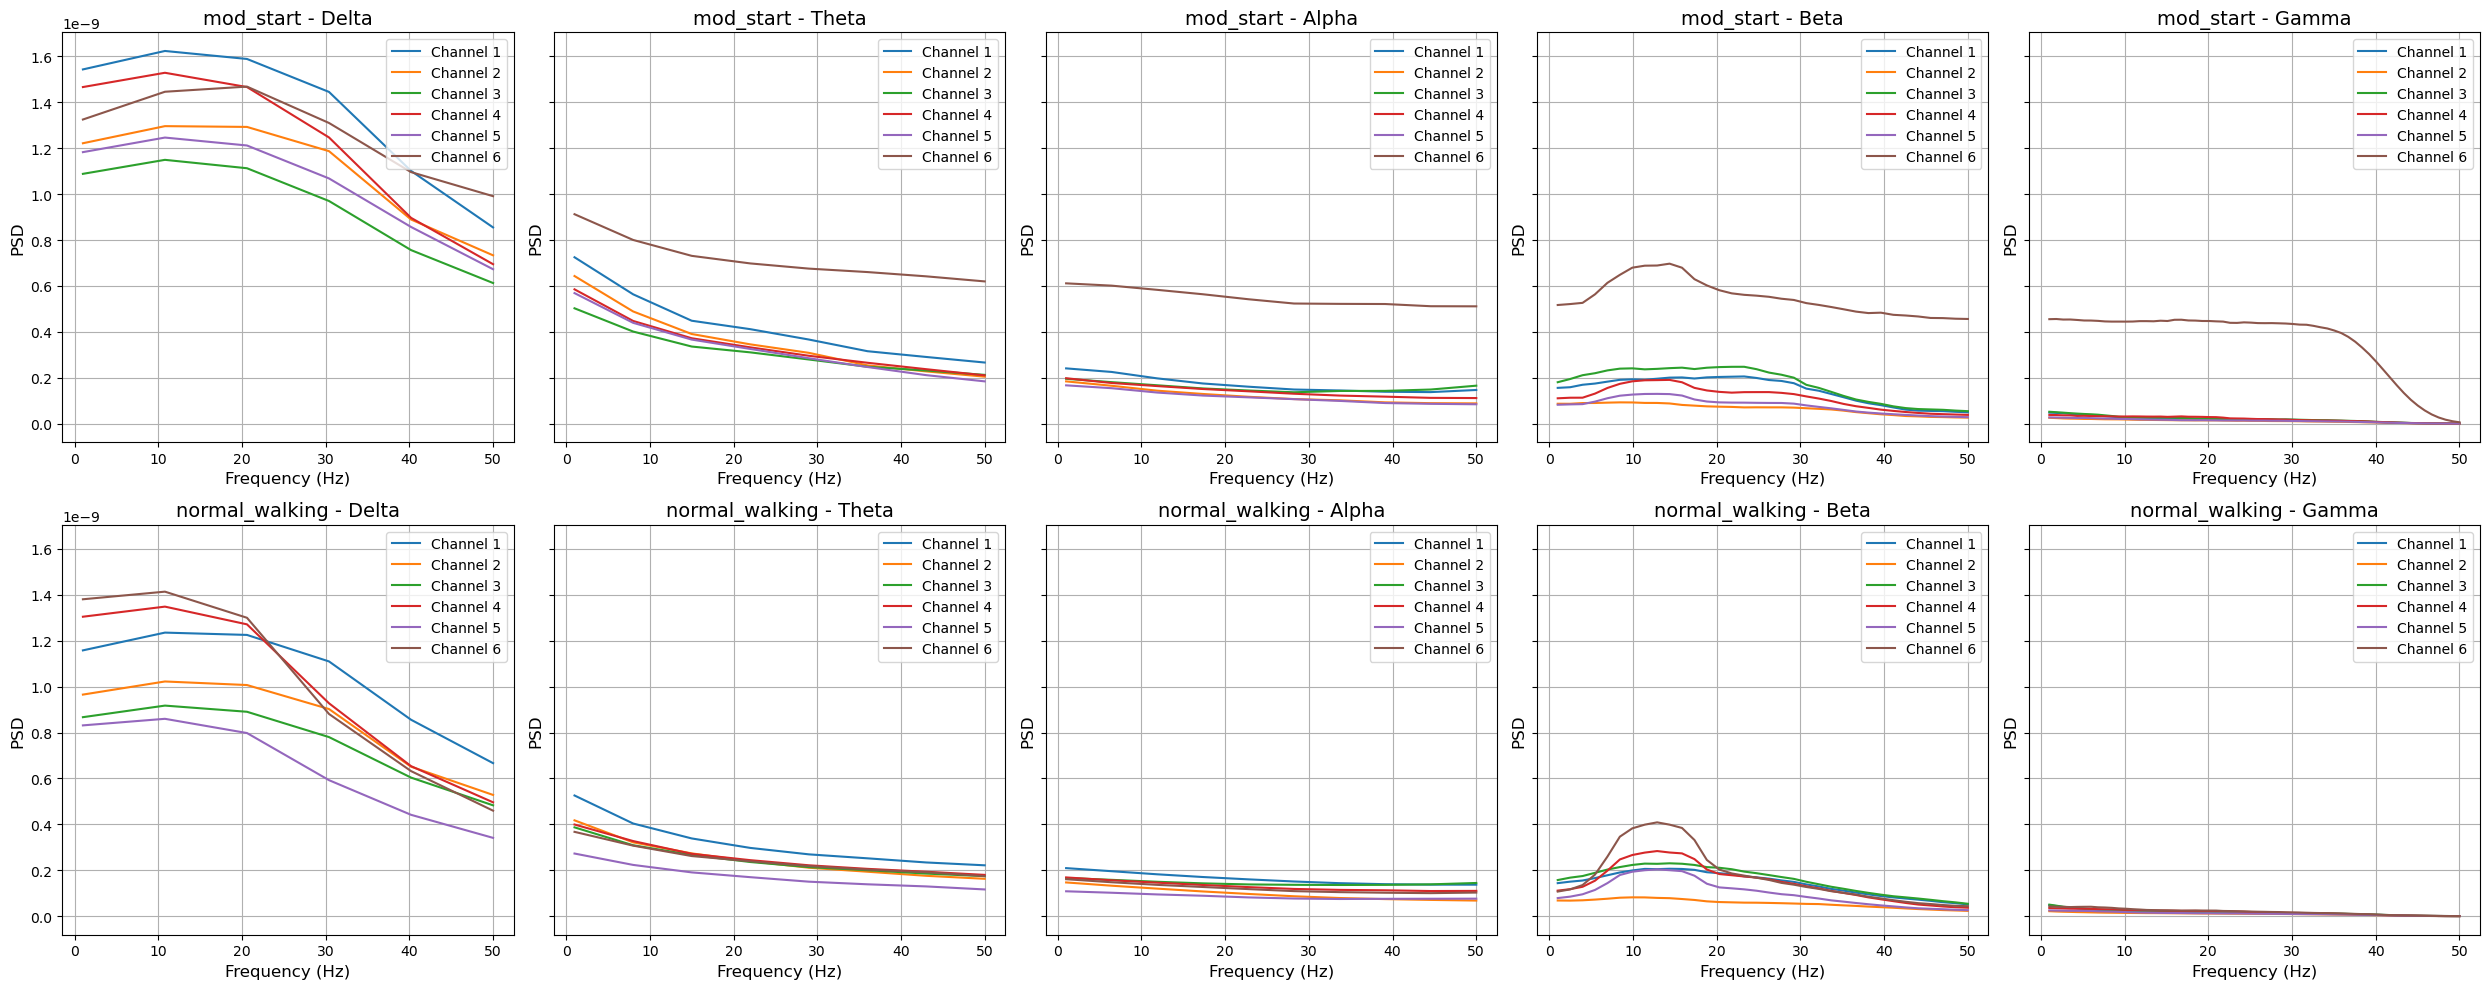

In [47]:
def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
    """
    Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking).
    
    Parameters:
    - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
                        values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - freq_bands: List or dictionary of frequency bands.
    """
    num_bands = len(freq_bands)
    num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
    num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

    fig, axes = plt.subplots(2, num_bands, figsize=(5 * num_bands, 10), sharey=True)

    # Plot PSD for mod_start
    for i, (band, values_mod) in enumerate(psd_features_mod.items()):
        mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs for mod_start
        freqs = np.linspace(1, 50, values_mod.shape[2])  # Example frequency range (adjust as necessary)
        
        for ch in range(num_channels_mod):
            axes[0, i].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for mod_start class
        axes[0, i].set_title(f'mod_start - {band.capitalize()}', fontsize=14)
        axes[0, i].set_xlabel('Frequency (Hz)', fontsize=12)
        axes[0, i].set_ylabel('PSD', fontsize=12)
        axes[0, i].grid(True)

    # Plot PSD for normal_walking
    for i, (band, values_norm) in enumerate(psd_features_norm.items()):
        mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs for normal_walking
        freqs = np.linspace(1, 50, values_norm.shape[2])  # Example frequency range (adjust as necessary)
        
        for ch in range(num_channels_norm):
            axes[1, i].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for normal_walking class
        axes[1, i].set_title(f'normal_walking - {band.capitalize()}', fontsize=14)
        axes[1, i].set_xlabel('Frequency (Hz)', fontsize=12)
        axes[1, i].set_ylabel('PSD', fontsize=12)
        axes[1, i].grid(True)

    # Add legends and adjust layout
    for ax in axes.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
psd_features_mod_start = extract_band_psd(epochs['mod_start'], freq_bands)
psd_features_normal_walking = extract_band_psd(epochs['normal_walking'], freq_bands)

visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)

In [17]:
overall_psd_features.shape

(757, 6, 98)

    Using multitaper spectrum estimation with 7 DPSS windows


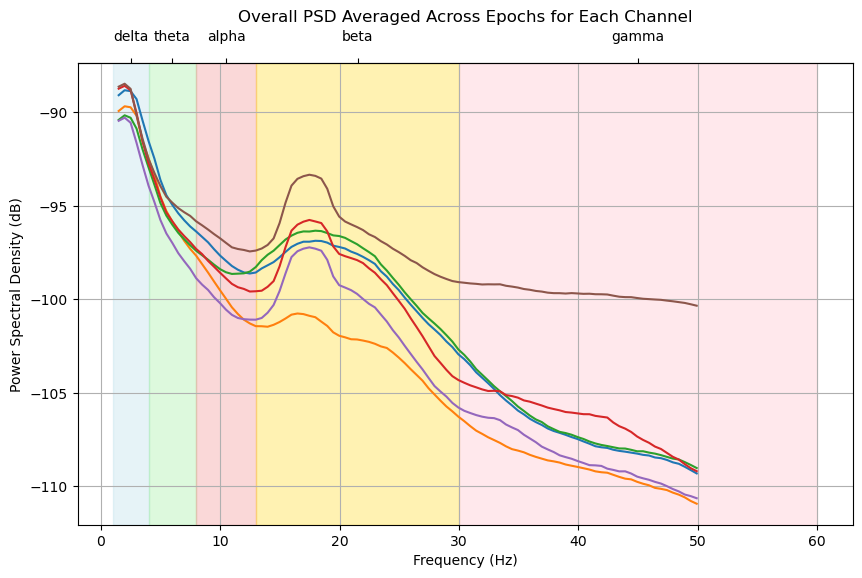

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def plot_overall_psd_with_bands(epochs, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD averaged across epochs for each channel, and marks the frequency bands with different colors and annotations.

    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """
    # Compute PSD across all epochs and channels, averaging across epochs
    psds, freqs = epochs.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mean = psds.mean(axis=0)  # Average across epochs
    
    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']

    # Plot overall PSD for each channel
    fig, ax = plt.subplots(figsize=(10, 6))
    for ch in range(psds_mean.shape[0]):  # Iterate over channels
        ax.plot(freqs, 10 * np.log10(psds_mean[ch]), label=f'Channel {ch+1}')

    # Mark frequency bands with distinct colors and create a secondary x-axis for band names
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        ax.axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)

    # Add secondary x-axis to display band names
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])  # Place ticks at the center of each band
    ax_top.set_xticklabels(freq_bands.keys())  # Set the band names as labels
    ax_top.tick_params(axis='x', pad=10)  # Adjust padding of the labels

    # Set labels and title
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB)')
    ax.set_title('Overall PSD Averaged Across Epochs for Each Channel')
    
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `epochs` is your MNE Epochs object and `freq_bands` is a dictionary of frequency bands
plot_overall_psd_with_bands(epochs, freq_bands)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


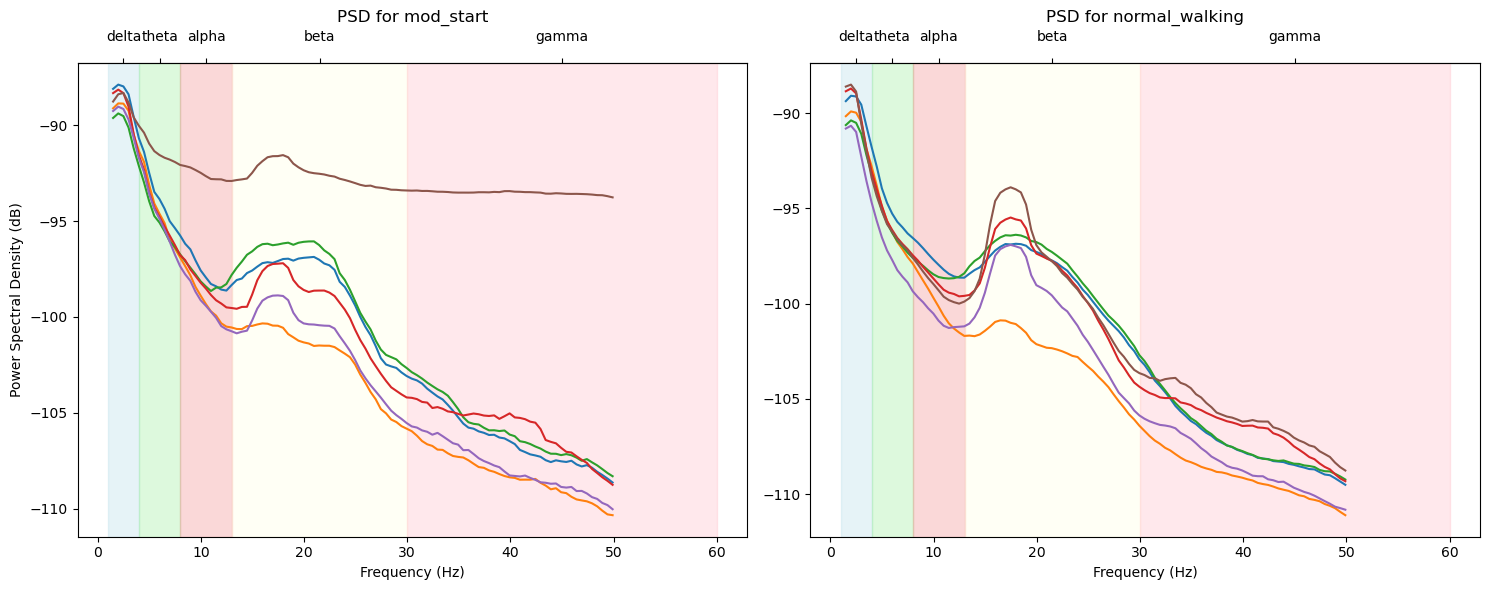

In [44]:
def plot_overall_psd_with_bands_by_class(epochs_mod, epochs_norm, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD for two classes (mod_start and normal_walking) in separate subplots,
    averaged across epochs for each class and channel. Frequency bands are marked with distinct colors.

    Parameters:
    - epochs_mod: MNE Epochs object for the mod_start class.
    - epochs_norm: MNE Epochs object for the normal_walking class.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """

    # Compute PSD for mod_start class
    psds_mod, freqs_mod = epochs_mod.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mod_mean = psds_mod.mean(axis=0)  # Average across epochs for mod_start

    # Compute PSD for normal_walking class
    psds_norm, freqs_norm = epochs_norm.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_norm_mean = psds_norm.mean(axis=0)  # Average across epochs for normal_walking

    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot PSD for mod_start
    for ch in range(psds_mod_mean.shape[0]):
        axes[0].plot(freqs_mod, 10 * np.log10(psds_mod_mean[ch]), label=f'Channel {ch+1}')
    axes[0].set_title('PSD for mod_start')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density (dB)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[0].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_mod = axes[0].secondary_xaxis('top')
    ax_top_mod.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_mod.set_xticklabels(freq_bands.keys())
    ax_top_mod.tick_params(axis='x', pad=10)

    # Plot PSD for normal_walking
    for ch in range(psds_norm_mean.shape[0]):
        axes[1].plot(freqs_norm, 10 * np.log10(psds_norm_mean[ch]), label=f'Channel {ch+1}')
    axes[1].set_title('PSD for normal_walking')
    axes[1].set_xlabel('Frequency (Hz)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[1].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_norm = axes[1].secondary_xaxis('top')
    ax_top_norm.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_norm.set_xticklabels(freq_bands.keys())
    ax_top_norm.tick_params(axis='x', pad=10)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_overall_psd_with_bands_by_class(epochs['mod_start'], epochs['normal_walking'], freq_bands)

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_58705/2796709754.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data().shape


(757, 6, 501)

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_combined(band_power_features, sfreq, ch_names):
    """
    Visualizes the band power features stored in a dictionary in a single plot,
    with each trace representing a channel and the x-axis representing frequency bands.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    - sfreq: float
        Sampling frequency of the data.
    - ch_names: list
        List of channel names corresponding to the data.
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())
    num_bands = len(freq_bands)

    # Prepare the y-axis data for each channel
    for ch_idx, ch_name in enumerate(ch_names):
        # Extract band power data for this channel
        channel_band_power = [band_power_features[band][:, ch_idx].mean() for band in freq_bands]

        # Plot each channel's band power across frequency bands
        plt.plot(freq_bands, channel_band_power, marker='o', label=ch_name)

    # Add titles and labels
    plt.title('Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Channels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data,
# `sfreq` is your sampling frequency, and `ch_names` is your list of channel names.
visualize_band_power_combined(band_power_features, lfp_sfreq, lfp_ch_names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_mean_std(band_power_features):
    """
    Visualizes the mean and standard deviation of band power features across channels
    in a single plot, with each trace representing the mean and std across channels.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())

    # Prepare the y-axis data for mean and std across channels
    mean_band_power = []
    std_band_power = []

    for band in freq_bands:
        # Compute the mean and standard deviation across channels for the current frequency band
        mean_power = band_power_features[band].mean(axis=1)  # Mean across channels
        std_power = band_power_features[band].std(axis=1)    # Std across channels
        
        mean_band_power.append(mean_power)  # Append the mean values
        std_band_power.append(std_power)      # Append the std values

    mean_band_power = np.array(mean_band_power)
    std_band_power = np.array(std_band_power)

    # Mean and std for plotting should be calculated correctly
    mean_band_power_mean = mean_band_power.mean(axis=1)
    mean_band_power_std = mean_band_power.std(axis=1)

    # Plotting the mean
    plt.plot(freq_bands, mean_band_power_mean, marker='o', label='Mean', color='blue')

    # Plotting the standard deviation as shaded area
    plt.fill_between(freq_bands, 
                     mean_band_power_mean - mean_band_power_std, 
                     mean_band_power_mean + mean_band_power_std, 
                     color='blue', alpha=0.3, label='Std Dev')

    # Add titles and labels
    plt.title('Mean Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Statistics')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data.
visualize_band_power_mean_std(band_power_features)

In [ ]:
epochs.compute_psd(fmax=60).plot()

In [ ]:
epochs.compute_psd(fmax=60).plot(average=True)


In [ ]:
# TODO: fix this
_, ax = plt.subplots()
spectrum = epochs.compute_psd(fmin=2.0, fmax=40.0, tmax=3.0, n_jobs=None)
# average across epochs first
mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)
# then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color="k")
ax.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
ax.set(
    title="Multitaper PSD (gradiometers)",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)

In [ ]:
epochs['mod_start'].plot_image(picks=[1])

In [ ]:
bad_epoch = np.argmin(epochs['mod_start'].get_data()[76, 5,:]) 
# epochs[76, 5, 54] = np.mean(epochs['mod_start'].get_data()[76, 5,:])
# epochs['mod_start'].get_data()[76, 5, 54]
epochs.drop(bad_epoch)

In [ ]:
# # def remove_outliers(epochs, threshold=3):

# # Compute the mean and standard deviation across epochs
# data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
# threshold=3

# # Reshape to (n_epochs, n_channels * n_times)
# reshaped_data = data.reshape(data.shape[0], -1)

# # Calculate z-scores
# z_scores = np.abs((reshaped_data - np.mean(reshaped_data, axis=0)) / np.std(reshaped_data, axis=0))

# # Identify outlier epochs
# outlier_epochs = np.where(z_scores > threshold)

# # Remove outlier epochs
# clean_epochs = epochs.copy().drop(outlier_epochs[0])

# # return clean_epochs

# # Usage
# 1
# # cleaned_epochs = remove_outliers(epochs)

In [ ]:
epochs, clean_epochs

# Baseline Model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_all_epochs_combined.get_data(copy=True)
X_test = test_all_epochs_combined.get_data(copy=True)

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

# Filtering the data

In [ ]:
# raw psd
raw_spectrum = raw_data_clean.compute_psd(method='welch', fmin=1, fmax=50, n_fft=2048)

psd_arr = raw_spectrum.get_data()
psd_freqs = raw_spectrum.freqs
print(raw_data_clean.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

raw_spectrum.plot()

In [ ]:
raw_spectrum.get_data().shape, raw_data_clean.get_data().shape

In [ ]:
# epochs psd: Train set
train_epoch_spectrum = train_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = train_epoch_spectrum.get_data()
psd_freqs = train_epoch_spectrum.freqs

print(train_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

train_epoch_spectrum.plot(average=False)

In [ ]:
train_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
train_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
# epochs psd: Test set
test_epoch_spectrum = test_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = test_epoch_spectrum.get_data()
psd_freqs = test_epoch_spectrum.freqs

print(test_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

test_epoch_spectrum.plot(average=False)

In [ ]:
test_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
test_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
train_all_epochs_combined.get_data().shape, train_epoch_spectrum.get_data().shape



# train_all_epochs_combined.events[:, -1].shape, test_all_epochs_combined.events[:, -1].shape

## Logistic Regression based on PSD

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_epoch_spectrum.get_data()
X_test = test_epoch_spectrum.get_data()

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# ICA raw
## CODE GOES HERE
ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
ica_95PCA.fit(inst=lfp_raw)
# ica_95PCA.plot_sources(inst=lfp_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# raw_ica_excluded = ica.apply(inst=lfp_raw.copy())
# raw_ica = ica.apply(inst=lfp_raw.copy())

# raw_ica_excluded.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')
# raw_ica.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')

In [ ]:
# # ICA rpochs
# ## CODE GOES HERE
# ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
# ica_95PCA.fit(inst=epochs_raw)
# ica_95PCA.plot_sources(inst=epochs_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# # Compute variance explained by PCA components
# explained_variance = ica.pca_explained_variance_ / np.sum(ica.pca_explained_variance_)

# print(f"Variance explained by PCA components: {explained_variance}")
# print(f"Variance explained by first 4 PCA components: {np.sum(explained_variance[:4]) * 100:.2f}%")

In [ ]:
# ica = mne.preprocessing.ICA(random_state=0)
# ica.fit(raw_sensors)

# # Remove the first ICA component (the random noise) from the data
# raw_cleaned = ica.apply(inst=raw_sensors.copy(), exclude=[1,2])
# raw_cleaned.plot(scalings='auto', title='clraned sensor signals (without noise)')

In [ ]:
epochs_raw["mod_start"].plot_image(combine="mean");

In [ ]:
mne.viz.plot_epochs_image(
    epochs_raw['mod_start'],
    picks=[0, 1, 2, 3, 4, 5],
    sigma=0.5,
    # combine="mean",
    # evoked=True
)

# Evoked

evoked_0 = epochs_raw['trial_start'].average()
evoked_4 = epochs_raw['mod_start'].average()

## Global Field Power (GFP)

The GFP is the population standard deviation of the signal across channels.

In [ ]:
fig0 = evoked_0.plot(gfp=True);
fig1 = evoked_1.plot(gfp=True);

In [ ]:
evoked_0.plot(gfp="only");
evoked_1.plot(gfp="only");

In [ ]:
gfp = evoked_0.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_0.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_0.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

In [ ]:
gfp = evoked_1.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_1.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_1.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

# # Time-frequency analysis

In [ ]:
freqs = np.arange(2, 50, 2) # Frequencies from 2 to 50 Hz
n_cycles = freqs / 2 # Number of cycles in Morlet wavelet


In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['mod_start'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['min_vel'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

# CSD

In [ ]:
csd_fft = mne.time_frequency.csd_fourier(train_all_epochs_combined, fmin=1, fmax=50)
csd_mt = mne.time_frequency.csd_multitaper(train_all_epochs_combined, fmin=1, fmax=50, adaptive=True)
frequencies = np.arange(1,51, 1)
csd_wav = mne.time_frequency.csd_morlet(train_all_epochs_combined, frequencies, decim=1)

In [ ]:
plot_dict = {
    "Short-time Fourier transform": csd_fft,
    "Adaptive multitapers": csd_mt,
    "Morlet wavelet transform": csd_wav,
}
for title, csd in plot_dict.items():
    (fig,) = csd.mean().plot()
    fig.suptitle(title)